# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('colorblind')

%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cross validation 
from sklearn.model_selection import train_test_split, StratifiedKFold

# hyper-parameter tuning
from sklearn.grid_search import GridSearchCV

# preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder

# models
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier

# pipeline
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, log_loss, 
                             brier_score_loss, precision_score, recall_score, f1_score, make_scorer)

from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', unicode(input_str))
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii


In [3]:
# taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [4]:
# taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
def plot_forest_importances(clf):
    importances = clf.feature_importances_

    important_names = my_features[importances > np.mean(importances)]
    print important_names

    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_test.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))
    plt.title("Feature importances")
    plt.bar(range(X_test.shape[1]), importances[indices], yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), my_features[indices], rotation=90)
    plt.xlim([-1, X_test.shape[1]])
    plt.show()


In [5]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

train_df['test'] = False
test_df['test'] = True

df = train_df.append(test_df).reset_index(drop=True)

In [6]:
df.bathrooms = df.bathrooms.map(lambda b: b if b < 10 else 0)
df.bedrooms = df.bedrooms.map(lambda b: b if b < 10 else 0)

In [7]:
df['bathrooms_as_int'] = df.bathrooms.round(0) # df.bathrooms.astype(int) # 1.5 -> 1

In [8]:
(lat_min, lat_max), lat_mean = np.percentile(df.latitude, [0.1, 99.9]).tolist(), np.mean(df.latitude)
(lon_min, lon_max), lon_mean = np.percentile(df.longitude, [0.1, 99.9]).tolist(), np.mean(df.longitude)

df.latitude = np.where(df.latitude < lat_min, lat_min, df.latitude)
df.latitude = np.where(df.latitude > lat_max, lat_max, df.latitude)

df.longitude = np.where(df.longitude < lon_min, lon_min, df.longitude)
df.longitude = np.where(df.longitude > lon_max, lon_max, df.longitude)

In [9]:
df['price_log'] = np.log(df.price)

In [10]:
price_max = np.percentile(df.price, 99).tolist()
df.price = np.where(df.price > price_max, price_max, df.price)

In [11]:
def clean_addresses(input_str):
    hexadecimals = re.compile('[^a-zA-Z0-9 ]').sub(' ', input_str).lower()
    
    hexadecimals = hexadecimals.replace(' avenue', ' ave').replace(' boulevard', ' blvd')\
        .replace(' street', ' st').replace(' road', ' rd')\
        .replace(' south', ' s').replace(' north', ' n').replace(' east', ' e').replace(' west', ' w')\
        .replace('south ', 's ').replace('north ', 'n ').replace('east ', 'e ').replace('west ', 'w ')\
        .split(" ")
    
    return " ".join([x.strip() for x in hexadecimals if x != ''])

In [12]:
df['street_address_ascii'] = [remove_accents(line) for line in df.street_address] 
df['street_address_clean'] = df.street_address_ascii.apply(clean_addresses)

In [13]:
bldg_id_counts = df.building_id.value_counts()
df['listings_in_bldg'] = df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

In [14]:
manager_id_counts = df.manager_id.value_counts()
df['listings_per_manager'] = df.manager_id.map(lambda b: manager_id_counts[b] if b != '0' else 1)

In [15]:
def do_lem(str):
    return " ".join([WordNetLemmatizer().lemmatize(word) for word in str.split(" ")])

def do_stem(str):
    return " ".join([PorterStemmer().stem(word) for word in str.split(" ")])

In [16]:
df['description_clean'] = df.description.apply(lambda alist: remove_accents(alist))

df.description_clean = [re.sub(r'[()?!@#$%^&*-;\'\"]', "", line).replace(","," ")\
                                 .replace("<br >", "").replace("<br />","").replace("<p>","").replace("</p>","")\
                                 .replace("<a  website_redacted", "")\
                                 .replace("apartment", "").replace("bedroom", "").replace("bathroom", "")
                                 .lower().strip() for line in df.description_clean]

df.description_clean = [re.sub(re.compile(r'\s+'), " ", line) for line in df.description_clean]
df.description_clean = [do_lem(line) for line in df.description_clean]

In [17]:
def clean_features(alist):
    return [unicode(x).lower().strip('!@#$%^&*()-_+=;,./\\\'\t').replace(' ', '').replace('-','') for x in alist if len(alist)>0 and isinstance(alist, list)]

In [18]:
df['features_clean'] = df.features.apply(lambda alist: clean_features(alist))

In [19]:
df['num_photos'] = df.photos.apply(len)
df['num_features'] = df.features.apply(len)
df['description_size'] = df.description.apply(lambda x: len(x.split(" ")))

In [20]:
df['created'] = pd.to_datetime(df.created)
df['month'] = df.created.dt.month
df['week'] = df.created.dt.week
df['hod'] = df.created.dt.hour
df['dow'] = df.created.dt.dayofweek

In [21]:
df['hod_shifted'] = df.created.dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.hour

In [22]:
df['bb_combined'] = df.bathrooms + df.bedrooms
df['price_per_room'] = df.price / df.bedrooms  
df['price_per_bath'] = df.price / df.bathrooms

In [23]:
geocoded_addresses = pd.read_csv('geocoded_addresses.csv', header=0, names=['city', 'county', 'country', 'lat', 'lon', 'neighbourhood', 'listing_id'])
geocoded_addresses.set_index([df.listing_id])

df = pd.concat([df, geocoded_addresses[['city','county','neighbourhood']]], axis=1)
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,week,hod,dow,hod_shifted,bb_combined,price_per_room,price_per_bath,city,county,neighbourhood
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,25,7,4,0,4.5,1000.0,2000.0,New York,Queens County,Long Island City
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,23,12,6,5,3.0,2732.5,5465.0,New York,New York County,Manhattan
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,15,3,6,20,2.0,2850.0,2850.0,New York,NaN,New York City


### Categorical features

Useful reading:

- http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/
- https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/


In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
df['month'] = le.fit_transform(df['month'])
df['week'] = le.fit_transform(df['week'])

df['neighbourhood'] = le.fit_transform(df['neighbourhood'])

In [25]:
len(df.neighbourhood.unique())

35

In [26]:
ohe = OneHotEncoder()

In [27]:
encoded = ohe.fit_transform(df.month.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['m1', 'm2', 'm3'])
df = df.merge(encoded, left_index=True, right_index=True)

In [28]:
encoded = ohe.fit_transform(df.week.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['w' + str(i+1) for i in range(14)])
df = df.merge(encoded, left_index=True, right_index=True)

In [29]:
encoded = ohe.fit_transform(df.neighbourhood.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['n' + str(i+1) for i in range(35)])
df = df.merge(encoded, left_index=True, right_index=True)

In [74]:
df_with_dummies = pd.get_dummies(df, prefix='N', columns=['neighbourhood'])

In [75]:
df_with_dummies.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,N_25,N_26,N_27,N_28,N_29,N_30,N_31,N_32,N_33,N_34
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.neighbourhood.head(5)

In [ ]:
dummies = pd.get_dummies(df['neighbourhood']).rename(columns=lambda x: 'n_' + str(x))
df = pd.concat([df, dummies], axis=1)
df = df.drop(['neighbourhood'], inplace=True, axis=1)

In [ ]:
df.neighbourhood.head(5)

### Features choosing

['bathrooms_as_int', 'bedrooms', 'latitude', 'longitude', 'price_log', 'listings_in_bldg', 'listings_per_manager', 'num_photos', 'num_features', 'description_size', 'hod', 'dow']

Score: 0.729511

Log-loss: 0.604222

Main features: ['latitude' 'longitude' 'price_log' 'listings_in_bldg' 'listings_per_manager' 'description_size']

['bathrooms_as_int', 'bedrooms', 'price_log', 
                        'listings_in_bldg', 'listings_per_manager', 
                        'num_photos', 'num_features', 'description_size', 
                        'm1', 'm2', 'm3', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10',
                        'w11', 'w12', 'w13', 'w14', 'dow',
                        'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10',
                        'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20',
                        'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30',
                        'n31', 'n32', 'n33', 'n34', 'n35']
                        
Score: 0.715125

Log-loss: 0.633959

Main features: ['bedrooms' 'price_log' 'listings_in_bldg' 'listings_per_manager'
 'num_photos' 'num_features' 'description_size' 'dow']

In [30]:
train_df = df[df.test == False]
test_df = df[df.test == True]

In [53]:
my_features = np.array(['bathrooms_as_int', 'bedrooms', 'price_log', 
                        'listings_in_bldg', 'listings_per_manager', 
                        'num_photos', 'num_features', 'description_size', 
                        'm1', 'm2', 'm3', 
                        'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13',  
                        'dow', 'hod_shifted',
                        'n25', 'n22', 'n21', 'n33', 'n5'])

In [54]:
X = train_df[my_features].copy()
y = train_df.interest_level.copy()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
len(my_features)

30

## Model training

In [57]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

y_prediction = clf.predict(X_test)
y_probability = pd.DataFrame(data=clf.predict_proba(X_test), columns=clf.classes_)
y_probability.reindex_axis(labels=['low', 'medium', 'high'])

print(classification_report(y_test, y_prediction))
print("Score: %f" % clf.score(X_test, y_test))           # prev: 0.727485
print("Log-loss: %f" % log_loss(y_test, y_probability))  # prev: 0.603970


             precision    recall  f1-score   support

       high       0.67      0.19      0.30       765
        low       0.75      0.95      0.84      6795
     medium       0.48      0.22      0.30      2311

avg / total       0.68      0.72      0.67      9871

Score: 0.722622
Log-loss: 0.614542
CPU times: user 1min 4s, sys: 2.24 s, total: 1min 6s
Wall time: 1min 6s


Confusion matrix, without normalization
[[ 148  378  239]
 [  16 6479  300]
 [  58 1747  506]]


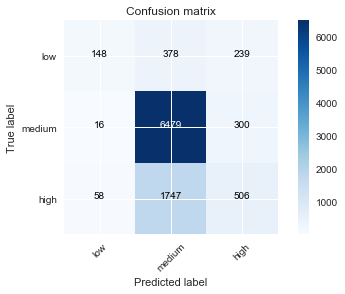

In [58]:
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

['bedrooms' 'price_log' 'listings_in_bldg' 'listings_per_manager'
 'num_photos' 'num_features' 'description_size' 'dow' 'hod_shifted']
Feature ranking:
1. feature 2 (0.163977)
2. feature 7 (0.113067)
3. feature 3 (0.105432)
4. feature 4 (0.103982)
5. feature 5 (0.077307)
6. feature 6 (0.076515)
7. feature 24 (0.073349)
8. feature 23 (0.056785)
9. feature 1 (0.045115)
10. feature 25 (0.012333)
11. feature 0 (0.011599)
12. feature 26 (0.011418)
13. feature 10 (0.010907)
14. feature 8 (0.010905)
15. feature 27 (0.010767)
16. feature 9 (0.010546)
17. feature 11 (0.008456)
18. feature 12 (0.008422)
19. feature 16 (0.008262)
20. feature 17 (0.008171)
21. feature 19 (0.008052)
22. feature 13 (0.008027)
23. feature 20 (0.007969)
24. feature 15 (0.007957)
25. feature 22 (0.007721)
26. feature 14 (0.007663)
27. feature 21 (0.006907)
28. feature 28 (0.006848)
29. feature 18 (0.006619)
30. feature 29 (0.004921)


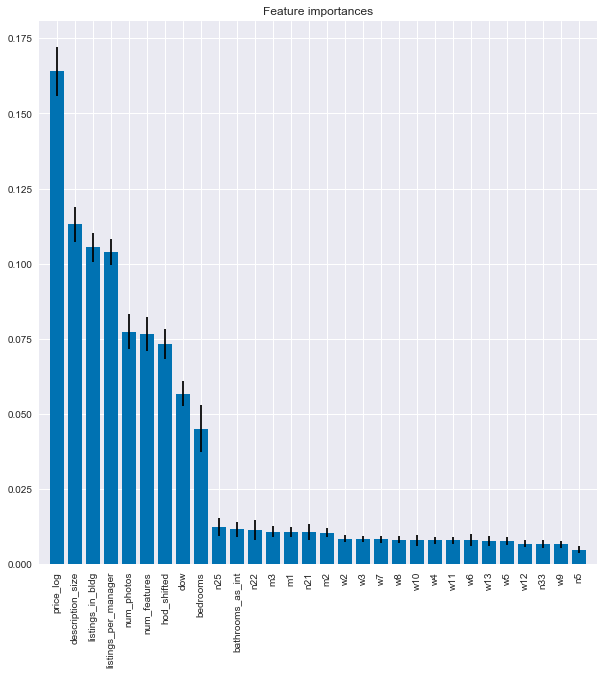

In [59]:
plot_forest_importances(clf)

Internal OOB validation

In [60]:
n_estimators = np.logspace(1, 3, 5).astype(int)
scores = []
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1).fit(X_train, y_train)
    scores.append(rf.oob_score_)

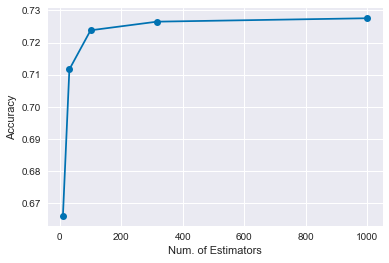

In [61]:
plt.plot(n_estimators, scores, '-o')
plt.xlabel('Num. of Estimators')
plt.ylabel('Accuracy')

In [62]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=10)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [63]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [64]:
get_xgb_imp(clf,my_features)

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


{'bathrooms_as_int': nan,
 'bedrooms': nan,
 'description_size': nan,
 'dow': nan,
 'hod_shifted': nan,
 'listings_in_bldg': nan,
 'listings_per_manager': nan,
 'm1': nan,
 'm2': nan,
 'm3': nan,
 'n21': nan,
 'n22': nan,
 'n25': nan,
 'n33': nan,
 'n5': nan,
 'num_features': nan,
 'num_photos': nan,
 'price_log': nan,
 'w10': nan,
 'w11': nan,
 'w12': nan,
 'w13': nan,
 'w2': nan,
 'w3': nan,
 'w4': nan,
 'w5': nan,
 'w6': nan,
 'w7': nan,
 'w8': nan,
 'w9': nan}

In [65]:
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': [10, 20, 30]}
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring=make_scorer(accuracy_score))

In [66]:
clf.fit(X_train, y_train)
print("Score: %f" % clf.score(X_test, y_test))

Score: 0.724648


['bedrooms' 'price_log' 'listings_in_bldg' 'listings_per_manager'
 'num_photos' 'num_features' 'description_size' 'dow' 'hod_shifted']
Feature ranking:
1. feature 2 (0.168221)
2. feature 7 (0.115164)
3. feature 3 (0.107795)
4. feature 4 (0.103323)
5. feature 5 (0.074266)
6. feature 24 (0.072716)
7. feature 6 (0.070348)
8. feature 23 (0.053214)
9. feature 1 (0.043259)
10. feature 25 (0.014279)
11. feature 26 (0.011944)
12. feature 27 (0.010218)
13. feature 8 (0.010127)
14. feature 10 (0.010016)
15. feature 19 (0.009867)
16. feature 9 (0.009705)
17. feature 15 (0.009591)
18. feature 16 (0.009417)
19. feature 11 (0.009269)
20. feature 17 (0.009115)
21. feature 12 (0.009094)
22. feature 14 (0.009052)
23. feature 13 (0.008947)
24. feature 22 (0.008860)
25. feature 20 (0.008360)
26. feature 0 (0.007818)
27. feature 18 (0.007459)
28. feature 21 (0.007343)
29. feature 28 (0.006571)
30. feature 29 (0.004642)


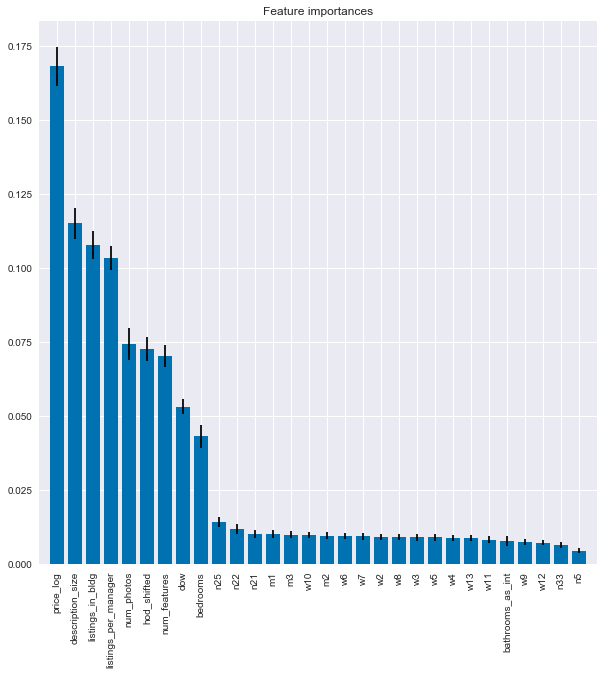

In [67]:
plot_forest_importances(clf.best_estimator_)

In [68]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])
pca.fit(X_train)

CPU times: user 106 ms, sys: 121 ms, total: 227 ms
Wall time: 181 ms


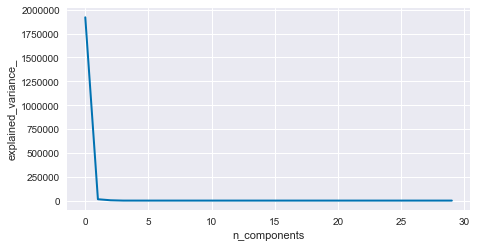

In [69]:
plt.figure(1, figsize=(8, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [ ]:
n_components = [10, 20, 30]

grid_search = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
grid_search.fit(X_train, y_train)

plt.axvline(grid_search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [ ]:
y_prediction = grid_search.predict(X_test)
print(classification_report(y_test, y_prediction))
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

In [ ]:
print(grid_search.best_estimator_.named_steps["clf"].feature_importances_)

In [ ]:
plot_forest_importances(grid_search.best_estimator_.named_steps["clf"])

# Submission saving

Submissions are evaluated using the multi-class logarithmic loss. Submit a set of predicted probabilities (one for every listing).

See details here: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries#evaluation

In [ ]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

y_prediction = clf.predict(X_test)
y_probability = pd.DataFrame(data=clf.predict_proba(X_test), columns=clf.classes_)
y_probability.reindex_axis(labels=['low', 'medium', 'high'])

print(classification_report(y_test, y_prediction))
print("Score: %f" % clf.score(X_test, y_test))           # prev: 0.727485
print("Log-loss: %f" % log_loss(y_test, y_probability))  # prev: 0.603970


In [ ]:
X = train_df[my_features]
y = clf.predict_proba(X)

In [ ]:
import datetime
today = datetime.date.today().strftime("%d-%m-%Y")

In [ ]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

In [ ]:
submission = pd.DataFrame()
submission['listing_id'] = train_df['listing_id']
for label in ['high', 'medium', 'low']:
    submission[label] = y[:, labels2idx[label]]
submission.to_csv('submission_%s.csv' % today, index=False)

In [ ]:
submission.head()